<a href="https://colab.research.google.com/github/lorenzophys/deep-learning-playground/blob/main/MNIST_digit_CNN_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST digit CNN with data augmentation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from keras.preprocessing.image import ImageDataGenerator

Loading the data from Keras.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

Check the shapes of the images.

In [ ]:
print('Train', train_images.shape, train_labels.shape)
print('Test', test_images.shape, test_labels.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


The images must be reshaped before being fed into the convolutional layer.

In [ ]:
train_images = train_images.reshape(-1,28,28,1)
test_images = test_images.reshape(-1,28,28,1)

print('Train', train_images.shape, train_labels.shape)
print('Test', test_images.shape, test_labels.shape)

Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28, 1) (10000,)


Normalization. Normally you should check, but I already know that the pixels range from 0 to 255.

In [ ]:
train_images, test_images = train_images/255., test_images/255.

I want to see if the model improves with data augmentation. Horizontal and vertical flip are set to false by default, but I wanted to explicity show that flipping is a bad idea when the data is not invariant under such transformations. Example: 9 and 6.

In [ ]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             shear_range=0.2,
                             height_shift_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=False,
                             vertical_flip=False)

For this experiment I chose batch normalization layers instead of dropuout. This allows me to reduce the internal covariate shift and speed up the training process. This also allows the net to avoid overfitting without using of dropout. [1]

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding="same", activation="relu"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 50
steps_per_epoch = train_images.shape[0]//64

In [ ]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                                  epochs=epochs, 
                                  steps_per_epoch=steps_per_epoch,  
                                  validation_data=(test_images, test_labels))

Max validation accuracy: 0.99620


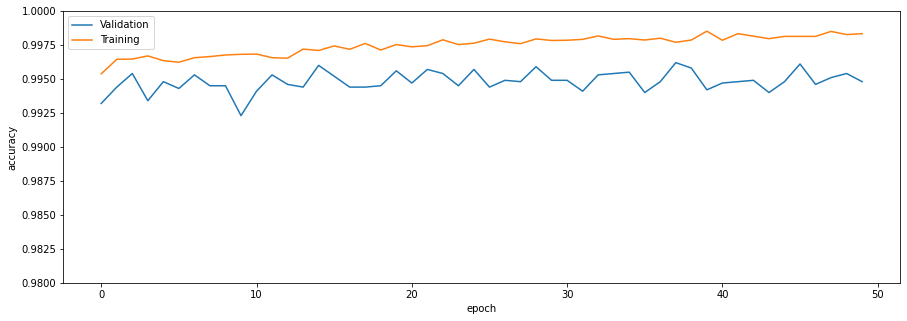

In [ ]:
print(f"Max validation accuracy: {np.max(model.history.history['val_accuracy']):.5f}")
plt.figure(figsize=(15,5))
plt.plot(model.history.history["val_accuracy"])
plt.plot(model.history.history["accuracy"])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["Validation", "Training"])
plt.gca().set_ylim([0.98,1])
plt.show()

[1] Ioffe S., Szegedy C., *Batch Normalization: Accelerating Deep Network Training byReducing Internal Covariate Shift*, 2015.
ArXiv: https://arxiv.org/pdf/1502.03167.pdf

Let's see what's the accuracy distribution. The plan was to train 100 models, but colab runs out of ram after the 30th model. So I stop at 25.

In [ ]:
ensemble = [0] * 100

In [ ]:
for i in range(100):
  ensemble[i] = keras.models.Sequential()

  ensemble[i].add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  ensemble[i].add(keras.layers.BatchNormalization())
  ensemble[i].add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding="same", activation="relu"))
  ensemble[i].add(keras.layers.BatchNormalization())

  ensemble[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
  ensemble[i].add(keras.layers.BatchNormalization())
  ensemble[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"))
  ensemble[i].add(keras.layers.BatchNormalization())

  ensemble[i].add(keras.layers.Flatten())
  ensemble[i].add(keras.layers.Dense(256, activation='relu'))
  ensemble[i].add(keras.layers.Dense(10, activation='softmax'))

  ensemble[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history_ensemble = [0] * 100
epochs_ensemble = 15
ensemble_accuracy = []

In [ ]:
for i in range(25):
  history_ensemble[i] = ensemble[i].fit(datagen.flow(train_images, train_labels, batch_size=64),
                                    epochs=epochs_ensemble, 
                                    steps_per_epoch=steps_per_epoch,  
                                    validation_data=(test_images, test_labels),
                                    verbose=0)
  ensemble_accuracy.append(np.max(history_ensemble[i].history['val_accuracy']))
  print(f"{i} Best accuracy: {np.max(history_ensemble[i].history['val_accuracy'])}")

0 Best accuracy: 0.9955999851226807
1 Best accuracy: 0.9954000115394592
2 Best accuracy: 0.9948999881744385
3 Best accuracy: 0.9952999949455261
4 Best accuracy: 0.9952999949455261
5 Best accuracy: 0.9952999949455261
6 Best accuracy: 0.9944000244140625
7 Best accuracy: 0.9939000010490417
8 Best accuracy: 0.9952999949455261
9 Best accuracy: 0.9952999949455261
10 Best accuracy: 0.9939000010490417
11 Best accuracy: 0.9948999881744385
12 Best accuracy: 0.9940999746322632
13 Best accuracy: 0.9950000047683716
14 Best accuracy: 0.994700014591217
15 Best accuracy: 0.9950000047683716
16 Best accuracy: 0.9943000078201294
17 Best accuracy: 0.994700014591217
18 Best accuracy: 0.9943000078201294
19 Best accuracy: 0.9947999715805054
20 Best accuracy: 0.9945999979972839
21 Best accuracy: 0.995199978351593
22 Best accuracy: 0.994700014591217
23 Best accuracy: 0.9945999979972839
24 Best accuracy: 0.9954000115394592


mu = 0.9948, std = 0.0005


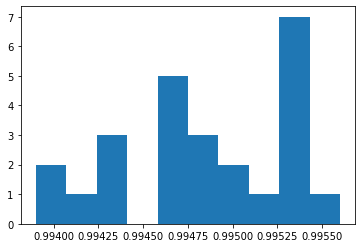

In [ ]:
mu, std = norm.fit(ensemble_accuracy)
print(f"mu = {mu:.4f}, std = {std:.4f}")
plt.hist(ensemble_accuracy, bins=10)
plt.show()